# Try ELM prediction on D3D_ELM dataset

This notebook illustrates how to use an LSTM to ELM prediction
It operates on a dataset that has been compiled using https://github.com/PPPLDeepLearning/dataset_ELM_full
The code for the `d3d_loaders` package is here: https://github.com/PlasmaControl/d3d_loaders

Note that the interface to `d3d_loaders` is still in flux (as of 2023-03), so some function may be 
out of date. (Either a different name, or slightly different arguments).


As of now, only the last 10 shots have been used when running `/projects/FRNN/dataset_ELM_full/instantiate.sh`
Re-run instantiate with all the `[-10:]` that are sprinkled in everywhere and you should get the
full dataset.


## NOTHING HERE HAS BEEN VALIDATED AS OF 03/30/2023
(RK): The only thing I checked is if the notebook runs. Please check if the input data
signals are useful, if the shots are selected correctly etc.


In [1]:
from os.path import join 
import numpy as np
import matplotlib.pyplot as plt
import yaml
import h5py
import random
from time import perf_counter

In [2]:
import logging 
logging.basicConfig(filename="FRNN-ELM-prediction.log",
                 filemode='a',
                 format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                 datefmt='%H:%M:%S',
                 level=logging.DEBUG)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [4]:
import sys
sys.path.append("/home/rkube/repos/d3d_loaders")

In [5]:
from d3d_loaders.time_sampling import sampler_causal, sampler_linearip, sampler_space
from d3d_loaders.standardizers import standardizer_mean_std
from d3d_loaders.d3d_loaders import Multishot_dataset
from d3d_loaders.samplers import BatchedSampler, BatchedSampler_multi, collate_fn_batched

In [6]:
# ML parameters
seq_length = 128   # Length of the sequence used to predict the Time-To-Disruption (TTD)
batch_size = 16     

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Fetch the dataset definition.
# The dataset was compiled with the code in
# https://github.com/PPPLDeepLearning/dataset_ELM_full
# So far, only the last 10 shots are downloaded
datapath = "/projects/FRNN/dataset_ELM_full/dataset"

# fetch dataset definition for list of predictors.
with open(join(datapath, "..", "dataset.yaml"), "r") as fp:
    dataset = yaml.safe_load(fp)

In [8]:
# Next we need to instantiate samplers.
# These are used when reading the signal data from HDF5 and resample the raw MDS/PTdata signals
# onto a common time-base
# Each shot has a different length. We therefore create separate re-samplers for each shot
# that will operate on the duration for each specific shot.
#
# The times t_max and t_min have been calculated when the dataset was instantiated.

# Load tmax from yaml
with open(join(datapath, "..", "shots_t_min_max.yaml"), "r") as fp:
    t_min_max_dict = yaml.safe_load(fp)

# The d3d_datasets expects a that the samplers for each shot are passed as a dictionary.
sampler_pred_dict = {}
sampler_targ_dict = {}

# Instantiate the samplers and store in the dict.
for shotnr in dataset["shots"][-10:]:
    tmin = t_min_max_dict[shotnr]["tmin"]
    tmax = t_min_max_dict[shotnr]["tmax"]
    sampler_pred_dict.update({shotnr: sampler_causal(tmin, tmax, 1.0, t_shift=0.0)})
    sampler_targ_dict.update({shotnr: sampler_linearip(tmin, tmax, 1.0, t_shift=0.0)})

In [9]:
# Signals are to be normalized to a mean and standard deviation that is calculated over all shots
# in the dataset. Again, these have been calculated during dataset instantiation and stored in a yaml file.
# Here we only need to read the results from that file and instantiate a standardizer for each predictor.
  
norm_dict = {}
with open(join(datapath, "..", "normalization.yaml"), "r") as fp:
    normalization = yaml.safe_load(fp)

for k, v in normalization.items():
    norm_dict[k] = standardizer_mean_std(v["mean"], v["std"])
    
# See if normalizers exists for each predictor
for k in dataset["predictors"]:
    print(f"{k}: - {norm_dict[k]}")

bmspinj: - standardizer_mean_std, mean=1169.182861328125, std=1194.6673583984375
bmstinj: - standardizer_mean_std, mean=1.0939099788665771, std=1.118424415588379
dssdenest: - standardizer_mean_std, mean=1.0103323459625244, std=1.0006935596466064
edensfit: - standardizer_mean_std, mean=1.7560621500015259, std=1.0492308139801025
efsbetan: - standardizer_mean_std, mean=0.27811330556869507, std=0.36982497572898865
efsli: - standardizer_mean_std, mean=0.5116583108901978, std=0.668502926826477
efswmhd: - standardizer_mean_std, mean=83739.5625, std=116632.0078125
etempfit: - standardizer_mean_std, mean=0.9828575849533081, std=0.9232432842254639
fs07: - standardizer_mean_std, mean=1.1474191962341376e+16, std=inf
ipeecoil: - standardizer_mean_std, mean=-0.06376415491104126, std=0.29224151372909546
ipsiptargt: - standardizer_mean_std, mean=0.9258556962013245, std=0.9238914251327515
ipspr15V: - standardizer_mean_std, mean=0.8620915412902832, std=0.9111335277557373
iptdirect: - standardizer_mean_s

In [10]:
dataset['shots'].sort()

In [11]:
# Instantiate a sampler for the profiles.
# Note that the ZIPFIT profiles, etempfit and edensfit are available for [0.0: 1.0]
# But the core profiles from Thomson scattering, ts_core_dens and ts_core_temp are only 
# available on roughly [0.03, 0.8]

with h5py.File(join(datapath, f"{dataset['shots'][-1]}.h5"), "r") as fp:
    print(f"Sampling point of thomson profile: {fp['/ts_core_dens/ydata'][:]}")

    profiles_min = 1.01 * fp['/ts_core_dens/ydata'][:].min()
    profiles_max = 0.99 * fp['/ts_core_dens/ydata'][:].max()



# This sampler_space object will resample all profiles over the range where thomson profiles
# are available. Now ELMs are in the edge and we may miss out on some accuarcy provided by
# zipfit profiles. But it should be a good way to get started.
#
#
# The relevant code that is executed when calling ip_profiles is
# the method __call__ in the class definition: https://github.com/PlasmaControl/d3d_loaders/blob/e071934eea02b7c593962145c42310d64093bcce/d3d_loaders/time_sampling.py#L108
# Note that it constructs a https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
# object. If the new x-values provided to this interpolator are out of bounds from the
# bounds stored in profiles_min, profiles_max this would throw an error. 

ip_profile = sampler_space(np.linspace(profiles_min, profiles_max, 32, dtype=np.float32))

Sampling point of thomson profile: [0.0303     0.0878     0.1493     0.2168     0.2688     0.3051
 0.3233     0.3638     0.39029998 0.4058     0.47779998 0.5313
 0.5513     0.5658     0.5808     0.5958     0.6113     0.62479997
 0.6328     0.6388     0.6473     0.65279996 0.66029996 0.66529995
 0.67279994 0.6793     0.6858     0.6918     0.69879997 0.7048
 0.7118     0.7173     0.7248     0.73029995 0.7368     0.7418
 0.7493     0.7553     0.7643     0.7768     0.78929996 0.8018
 0.8153     0.8253    ]


In [12]:
# To a random test/train split over the shots.
# As of now, only the last 10 shots are there.
# Re-run instantiate without that and we get the entire dataset.
shot_list = dataset["shots"][-10:]
random.shuffle(shot_list)

print(shot_list)

# Split
num_shots = len(shot_list)
num_train = 8
num_valid = 2

shots_train = shot_list[:num_train]
shots_valid = shot_list[num_train:num_train + num_valid]

[187328, 187324, 187320, 187326, 187321, 187316, 187317, 187323, 187322, 187325]


In [13]:
# Create the training set. This fetches all signals for all shots from HDF5 files and loads them
# into memory (torch.device("cpu")). Pass the previously instantiated samplers and standardizers
# to resample and normalize the raw signals that are stored in HDF5 files. The data in memory is then
# resampled and normalized.
ds_train = Multishot_dataset(shots_train, dataset["predictors"], ["ttelm"],
                             sampler_pred_dict, sampler_targ_dict, ip_profile, norm_dict, datapath, torch.device("cpu"))


In [14]:
# Print out info on the shots and lengths of the training set
shot_length_train = []
for ix, shotnr in enumerate(shots_train):
    shot_length_train.append(ds_train.shot(ix).__len__())
    print(f"shot {shotnr}, length: {shot_length_train[-1]}")

shot 187328, length: 1260
shot 187324, length: 4220
shot 187320, length: 40
shot 187326, length: 4220
shot 187321, length: 40
shot 187316, length: 4220
shot 187317, length: 4220
shot 187323, length: 4220


In [16]:
# Create the validation set in the same manner as the training set
ds_valid = Multishot_dataset(shots_valid, dataset["predictors"], ["ttelm"],
                             sampler_pred_dict, sampler_targ_dict, ip_profile, norm_dict, datapath, torch.device("cpu"))

In [17]:
# Print info on validation set
shot_length_valid = []
for ix, shotnr in enumerate(shots_valid):
    shot_length_valid.append(ds_valid.shot(ix).__len__())
    print(f"shot {shotnr}, length: {shot_length_valid[-1]}")

shot 187322, length: 4220
shot 187325, length: 4220


Text(0, 0.5, 'TTELM')

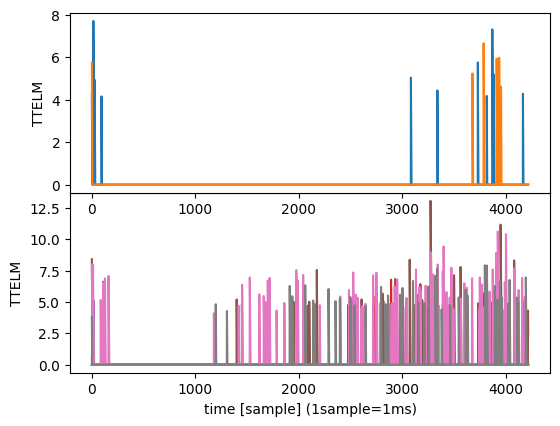

In [19]:
# Plot TTELM target for test and validation sets
fig = plt.figure()
ax_tr = fig.add_axes([0.2, 0.2, 0.75, 0.375])
ax_vl = fig.add_axes([0.2, 0.575, 0.75, 0.375])


for ix_shot in range(len(ds_train.datasets)):
    ax_tr.plot(ds_train.shot(ix_shot).targets["ttelm"].data)
    
for ix_shot in range(len(ds_valid.datasets)):
    ax_vl.plot(ds_valid.shot(ix_shot).targets["ttelm"].data)
    
ax_tr.set_xlabel("time [sample] (1sample=1ms)")
ax_tr.set_ylabel("TTELM")
ax_vl.set_ylabel("TTELM")

In [20]:
# Instantiate a loader for the training set.
# This loader picks 'batch_size' sequences of size seq_length+1 at random starting points, distributed across shots.
# Use shuffle=True to shuffle the dataset. Note that the sampler sets a seed for shuffling. During training
# we have to manually set the seed so that the shuffling will be different in every epoch
sampler_train = BatchedSampler_multi(shot_length_train, seq_length, batch_size, shuffle=True)

loader_train = DataLoader(ds_train,
                         batch_sampler=sampler_train, 
                         collate_fn=collate_fn_batched())

In [21]:
# Verify that we can iterate over all sequences and print timing info. Print out info on the shape of
# the returned tensors in the first epoch.
# Dimemsions should be [seq_length+1, batch_size, number_of_predictors] for x
# and [seq_length+1, batch_size, number_of_targets] for y.
# Number of predictors len(d3d_100["predictors"]), since each predictor only has one channel.
# Number of targets is 1, since we only predict 'ttd'
out = True
t_start = perf_counter()
for x, y in loader_train:
    if out:
        print(x.shape, y.shape, type(x), x.dtype, type(y), y.dtype)
        out = False
    continue
t_end = perf_counter()
print(f"1 iteration over dataset takes {(t_end - t_start):7.3f}s")

torch.Size([129, 16, 212]) torch.Size([129, 16, 1]) <class 'torch.Tensor'> torch.float32 <class 'torch.Tensor'> torch.float32
1 iteration over dataset takes  18.160s


In [22]:
sampler_valid = BatchedSampler_multi(shot_length_valid, seq_length, batch_size, shuffle=True)

loader_valid = DataLoader(ds_valid,
                          batch_sampler=sampler_valid,
                          collate_fn=collate_fn_batched())

In [23]:
# This cell prints out the 

out = True
t_start = perf_counter()

for x, y in loader_valid:
    if out:
        print(x.shape, y.shape, type(x), x.dtype, type(y), y.dtype)
        out = False
    continue
t_end = perf_counter()
print(f"1 iteration over validation dataset takes {(t_end - t_start):7.3f}s")

torch.Size([129, 16, 212]) torch.Size([129, 16, 1]) <class 'torch.Tensor'> torch.float32 <class 'torch.Tensor'> torch.float32
1 iteration over validation dataset takes   6.886s


In [24]:
# Define a simple LSTM model

class my_lstm(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, seq_length, num_layers=2):
        super(my_lstm, self).__init__()
        self.num_classes = num_classes  # Number of output features
        self.input_size = input_size    # Number of features in the input x
        self.hidden_size = hidden_size  # Number of features in hidden state h
        self.seq_length = seq_length  
        self.num_layers = num_layers
        self.device = device
        
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            batch_first=False) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc_2 = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        
        hn = hn[-1, ...]    # Take output of the last hidden recurrent layer
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out)  # Final Output
        return out

In [25]:
# Instantiate the model. num_classes=1, since the output is a 1d sequence (the TTD).
# input_size is just the number of predictors (remember, 1 channel per predictor)
# We grab the input size from the tensor x in the cells above where we time the
# duration for iterating over the entire dataset

inp_size = x.shape[2]

model = my_lstm(1, inp_size, hidden_size=128, seq_length=seq_length, num_layers=4).to(device)

# Calculate parameters
n_param = 0
for param in model.parameters():
    n_param += param.nelement()
print(f"{n_param} parameters")

588033 parameters


In [26]:
# Create a loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [28]:
# Train the model. This uses about 15-40% GPU on a single A100, depending on the size of the model.

num_epochs = 20

losses_train = np.zeros(num_epochs)
losses_valid = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # Remember to update the epoch of the samplers to use a new seed for sample shuffling
    sampler_train.set_epoch(epoch)
    sampler_valid.set_epoch(epoch)

    t_start = perf_counter()
    model.train()

    loss_train = 0.0
    loss_valid = 0.0
    ix_bt = 0
    for inputs, target in loader_train:
        inputs = inputs.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        output = model(inputs[:-1, :, :])

        loss = loss_fn(output, target[-1,:,:])
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        #print(f"batch {ix_b}: loss = {loss.item()}")
        ix_bt += 1
    
    ix_bv = 0
    with torch.no_grad():
        for inputs, target in loader_valid:
            inputs = inputs.to(device)
            target = target.to(device)
            
            output = model(inputs[:-1, :, :])
        
            loss_valid += loss_fn(output, target[-1, :, :]).item()
            ix_bv += 1
            
    losses_train[epoch] = loss_train / ix_bt / batch_size
    losses_valid[epoch] = loss_valid / ix_bv / batch_size
    t_end = perf_counter()
    t_epoch = t_end - t_start
    
    
    print(f"Epoch {epoch} took {t_epoch:7.3f}s. train loss = {losses_train[epoch]:8.6e}, valid loss =  {losses_valid[epoch]:8.6e}")


Epoch 0 took  38.693s. train loss = 4.813411e-02, valid loss =  7.674111e-03
Epoch 1 took  36.643s. train loss = 4.819236e-02, valid loss =  1.121221e-02
Epoch 2 took  36.758s. train loss = 4.892590e-02, valid loss =  8.710471e-03
Epoch 3 took  36.644s. train loss = 4.859795e-02, valid loss =  7.019756e-03
Epoch 4 took  36.806s. train loss = 4.675786e-02, valid loss =  7.423102e-03
Epoch 5 took  36.574s. train loss = 4.649268e-02, valid loss =  9.220318e-03
Epoch 6 took  36.807s. train loss = 4.585446e-02, valid loss =  7.118689e-03
Epoch 7 took  36.637s. train loss = 4.582426e-02, valid loss =  9.884950e-03
Epoch 8 took  36.598s. train loss = 4.670824e-02, valid loss =  1.443166e-02
Epoch 9 took  36.593s. train loss = 4.548800e-02, valid loss =  7.593466e-03
Epoch 10 took  36.547s. train loss = 4.603205e-02, valid loss =  9.347697e-03
Epoch 11 took  37.037s. train loss = 4.529770e-02, valid loss =  1.161905e-02
Epoch 12 took  36.557s. train loss = 4.496503e-02, valid loss =  1.204924e

In [29]:
for ix_shot in range(len(ds_valid)):
    loader_seq = DataLoader(ds_valid.shot(ix_shot),
                            batch_sampler=BatchedSampler(shot_length_valid[ix_shot], seq_length, batch_size, shuffle=False),
                            collate_fn=collate_fn_batched())
    
    output_pred = np.zeros(shot_length_valid[ix_shot])
    output_true = np.zeros(shot_length_valid[ix_shot])
    for ix, (x, y) in enumerate(loader_seq):
        inputs = x.to(device)
        output = model(inputs[:-1, :, :])
        # Skip partial batches
        if output.shape[0] == batch_size:
            output_pred[seq_length + (ix * batch_size):seq_length + ((ix + 1) * batch_size)] = output[:, 0].detach().cpu()
            output_true[seq_length + (ix * batch_size):seq_length + ((ix + 1) * batch_size)] = y[-1, :, 0].detach().cpu()
        
    plt.figure()
    plt.plot(output_true[seq_length:], label="True")
    plt.plot(output_pred[seq_length:], label="Predicted")
    plt.title(f"Shot {ds_valid.shot(ix_shot).shotnr}")
    plt.xlabel("time [samples] (1 sample = 1ms)")
    plt.ylabel("log(ttd)")
    plt.legend(loc="lower left")
    plt.savefig(f"plots/FRNN_ELM_prediction_{ds_valid.shot(ix_shot).shotnr}.png")

RuntimeError: Default process group has not been initialized, please make sure to call init_process_group.